In [1]:
from IPython.display import Image

# Unstructured Grids
Traditionally, lots of environmental data has been stored on latitude/longitude grids. This form of regular, rectilinear grid is easy to store and work with, but has a major problem when applied to a spherical Earth: grids points near the poles are much closer together. This both means that grid is not equal area, but also wastes storage space on tiny grid cells.

As data volumes increase, and particularly as models become higher resolution, the demands for better grids for environmental data has increased. This has led to a large number of "unstructured" grids being developed, that have equal grid spacing all over the globe. Unlike a rectilinear grid, these can't be described by a simple set of dimensions, but instead need to know which points connect to their neighbours to work on. Fortunately we have some tools which handle this for us!

## HEALPix
HEALPix (Hierarchical Equal Area isoLatitude Pixelization) is a useful method for divding a sphere into tiles of equal area, such that the tiles are also arranged in ways that can make certain computations on the sphere very efficient. 

It was created by astronomers studying the cosmic microwave background radiation, but also gets used in environmental data analysis. (See e.g. Gorski, K. M., Hivon, E., Banday, A. J., Wandelt, B. D., Hansen, F. K., Reinecke, M., & Bartelmann, M. (2005). HEALPix: A framework for high-resolution discretization and fast analysis of data distributed on the sphere. The Astrophysical Journal)

One recent high profile use of it was by DeepMind in a recent paper where they train neural networks to compress atmospheric data: https://arxiv.org/abs/2407.11666

### Resources:
HEALPix website: https://healpix.jpl.nasa.gov/ \
The HEALPix primer: https://arxiv.org/abs/astro-ph/9905275 \
healpy documentation: https://healpy.readthedocs.io/en/latest/ \
astropy_healpix docs: https://astropy-healpix.readthedocs.io/

The basic idea, is that the sphere is first divided into 12 pixels of equal area; these can then be successively subdivided to create finer and finer resolutions. Whatever the resolution though, the pixels always have the same area (unlike e.g. Lat/Lon grids where the area decreases towards the poles)

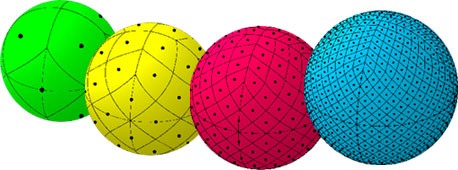

In [2]:
Image(filename='HealpixGridRefinement.jpg') # [Image By NASA and Caltech]

We will use the healpy package here, although there is also the astropy_healpix package. Much of this tutorial follows the healpy tutorial found here: https://healpy.readthedocs.io/en/latest/tutorial.html

In [3]:
import os
import numpy as np
import healpy as hp
import uxarray
from pathlib import Path
import matplotlib.pyplot as plt

notebook_dir = os.getcwd()
data_dir = str(Path(notebook_dir).parents[1] / 'data_samples' / 'healpix')

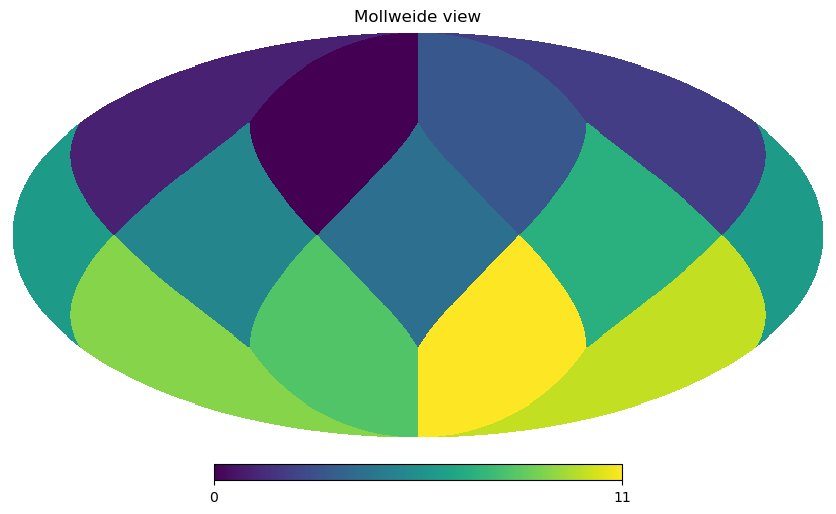

In [4]:
# A key parameter is NSIDE, a power of 2 which determines how many times the original 12 tiles are subdivided.
# Let's look at NSIDE=1, which is the basic tiling of the sphere with 12 tiles
NSIDE=1
NPIX = hp.nside2npix(NSIDE)

m = np.arange(NPIX)

# show a map where each pixel is coloured according to its index, using the Mollweide projection
hp.mollview(m)

There are two ways of ordering the points in HEALPix; in Ring ordering or 'Nested' ordering. Each one has different uses, and can make certain computations more efficient. 

The 'Ring' ordering means that pixels are indexed from top to bottom and left to right. This is the default ordering, and is used to perform Spherical Harmonic transforms.

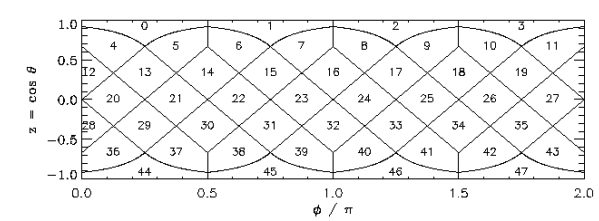

In [5]:
Image(filename='ring_ordering.png') # Source: Gorski, Krzysztof M., et al. "The healpix primer." arXiv astro-ph/9905275 (1999).

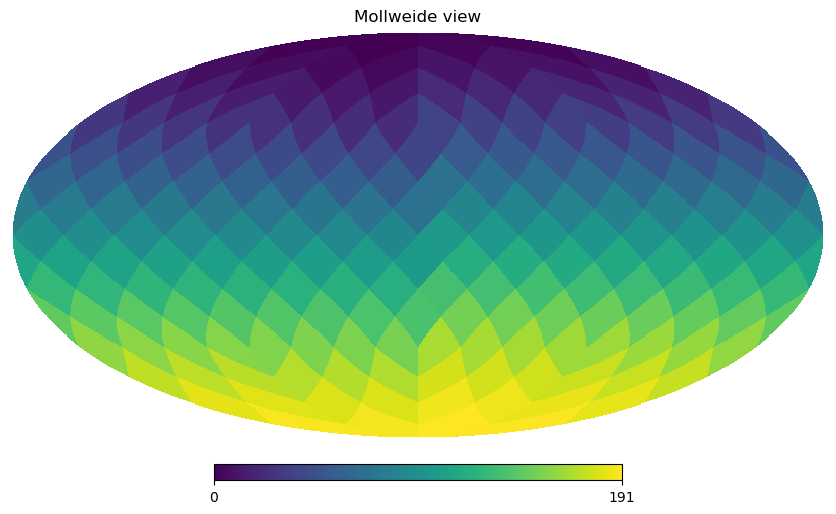

In [6]:
# The colours on this plot show how the indexes are arranged on the sphere; darker areas indicate low indexes and light areas indicate high indexes. Note how the index value generally increases from top to bottom (and left to right, although it is harder to tell from this image, but observe the discontinuity at the central line)

NSIDE=4
NPIX = hp.nside2npix(NSIDE)

m = np.arange(NPIX)
hp.mollview(m, nest=False)

The 'Nested' ordering means that pixels are indexed in a heirarchical way; starting from the largest scale and progressing downwards. 

This type of ordering is useful for operations that require grouping over areas on the sphere

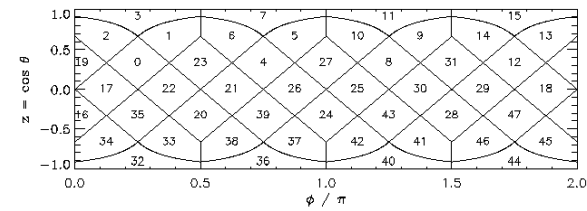

In [7]:
Image(filename='nest_ordering.png') # Source: Gorski, Krzysztof M., et al. "The healpix primer." arXiv astro-ph/9905275 (1999).

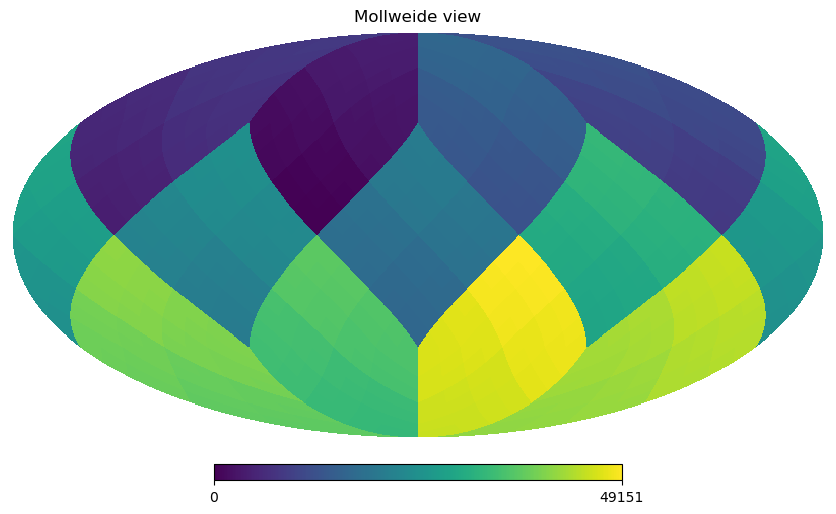

In [8]:
# Again, darker areas indicate low indexes and light areas indicate high indexes. Note how for the nested case, each tile is located near others with similar indexes
NSIDE=64
NPIX = hp.nside2npix(NSIDE)

m = np.arange(NPIX)
hp.mollview(m, nest=True)

## uxarray: working with unstructured grids
`uxarray` is a python module designed to extent the cabilities of xarray to unstructured grids

First, lets get some model data in healpix format:

In [9]:
import intake

cat = intake.open_catalog("https://data.nextgems-h2020.eu/online.yaml")
dataset = cat.ICON.ngc4008(time="P1D", zoom=4).to_dask()

/Users/jonesw/miniforge3/envs/iecdt_eda/lib/python3.10/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


Let's select the precipitation data for today's date:

In [10]:
from datetime import datetime
precip = dataset.pr.sel(time=datetime.now(), method="nearest")

In [11]:
precip

<xarray.DataArray 'pr' (cell: 3072)> Size: 12kB
[3072 values with dtype=float32]
Coordinates:
    time     datetime64[ns] 8B 2025-10-24
Dimensions without coordinates: cell
Attributes:
    cell_methods:  time: mean cell: mean
    component:     atmo
    grid_mapping:  crs
    long_name:     precipitation flux
    units:         kg m-2 s-1
    vgrid:         surface

As you can see, the precipitation variable only has one dimension, the cell number. To get the coordinates in latitude and longitude we additionally need a `uxarray` grid file

In [13]:
healpix_grid = uxarray.Grid.from_healpix(zoom=4)
healpix_grid

<uxarray.Grid>
Original Grid Type: HEALPix
Grid Dimensions:
  * n_face: 3072
Grid Coordinates (Spherical):
  * face_lon: (3072,)
  * face_lat: (3072,)
Grid Coordinates (Cartesian):
Grid Connectivity Variables:
Grid Descriptor Variables:

The grid file contains the lat and lon of each point, and can also be used by `uxarray` to calculate the connectivity between grid points. We can now turn our `xarray` precip dataarray into a `uxarray` UxDataArray by combining it with our grid file:

In [14]:
precip = uxarray.UxDataArray.from_xarray(
    precip, healpix_grid
)

In [15]:
precip

<xarray.UxDataArray 'pr' (n_face: 3072)> Size: 12kB
[3072 values with dtype=float32]
Coordinates:
    time     datetime64[ns] 8B 2025-10-24
Dimensions without coordinates: n_face
Attributes:
    cell_methods:  time: mean cell: mean
    component:     atmo
    grid_mapping:  crs
    long_name:     precipitation flux
    units:         kg m-2 s-1
    vgrid:         surface

We can now plot our data using uxarray:

In [18]:
import cartopy.crs as ccrs
precip.plot(periodic_elements="split", cmap="viridis", projection=ccrs.Robinson(), width=800, height=400)

:Image   [Longitude,Latitude]   (Longitude_Latitude pr)

## Selecting data
`uxarray` provides several tools for selecting data, including nearest neighbour, radius search, and within a bounding box:

In [21]:
precip.subset.nearest_neighbor([1.26, 51.75], k=1) # Find the nearest point to Oxford

<xarray.UxDataArray 'pr' (n_face: 1)> Size: 4B
array([2.672919e-05], dtype=float32)
Coordinates:
    time     datetime64[ns] 8B 2025-10-24
Dimensions without coordinates: n_face
Attributes:
    cell_methods:  time: mean cell: mean
    component:     atmo
    grid_mapping:  crs
    long_name:     precipitation flux
    units:         kg m-2 s-1
    vgrid:         surface

#### Exercise:
Use the `.subset.bounding_box` method to select the UK region, and plot it

Tip:
  - use the keyword `periodic_elements="exclude"` when plotting for non-global plots

In [22]:
...

Ellipsis

## Remapping data
Sometimes we need to map our data from one grid to another. `uxarray` also handles this!

First, we need to create a target grid which we want to remap to. For this, let's create a lat/lon grid from points:

In [24]:
lats, lons = np.meshgrid(np.arange(-85,90,10), np.arange(-175,180,10), indexing="ij")

In [30]:
latlon_grid = uxarray.Grid.from_points(
    (lats.ravel(), lons.ravel()), method="spherical_voronoi"
)

Then we can remap using the `remap` method:

In [31]:
precip_latlon = precip.remap.nearest_neighbor(destination_grid=latlon_grid)

In [32]:
precip_latlon.plot(periodic_elements="split", cmap="viridis", projection=ccrs.Robinson(), width=800, height=400)

/Users/jonesw/miniforge3/envs/iecdt_eda/lib/python3.10/site-packages/antimeridian/_implementation.py:594: FixWindingWarning: The exterior ring of this shape is wound clockwise. Since this is a common error in real-world geometries, this package is reversing the exterior coordinates of the input shape before running its algorithm. If you know that your input shape is correct (i.e. if your data encompasses both poles), pass `fix_winding=False`.
  FixWindingWarning.warn()
/Users/jonesw/miniforge3/envs/iecdt_eda/lib/python3.10/site-packages/antimeridian/_implementation.py:395: FixWindingWarning: The exterior ring of this shape is wound clockwise. Since this is a common error in real-world geometries, this package is reversing the exterior coordinates of the input shape before running its algorithm. If you know that your input shape is correct (i.e. if your data encompasses both poles), pass `fix_winding=False`.
  FixWindingWarning.warn()


:Image   [Longitude,Latitude]   (Longitude_Latitude pr)